# pdbeccdutils

This exercise demonstrates the use of the [pdbeccdutils](https://github.com/PDBeurope/ccdutils) - a set of python tools for working with small molecule components in the Protein Data Bank archive. 

You can use two main resources as input data for the package. [wwPDB CCD](http://www.wwpdb.org/data/ccd) contains models of all the ligands e.g. drug molecules, cofactors etc. commonly found in the PDB archive, whereas [wwPDB BIRD](http://www.wwpdb.org/data/bird) is composed of biologically interesting polymeric molecules such as peptides or oligosaccharides.

CCD components can be downloaded as a bundle either from [wwPDB FTP area](ftp://ftp.wwpdb.org/pub/pdb/data/monomers/components.cif.gz), or from [PDBe FTP area](http://ftp.ebi.ac.uk/pub/databases/msd/pdbechem_v2/components.cif). The components from the PDBe area are enriched with information about common fragments found in the molecules, their molecular scaffolds as well as links to popular small molecule chemistry databases. You can also use PDBeChem to download individual components from the following link using proper CCD id substitution: <ftp://ftp.ebi.ac.uk/pub/databases/msd/pdbechem_v2/H/HEM/HEM.cif>.

'BIRD' molecules can be downloaded in the *.tar.gz format from the following location: <ftp://ftp.wwpdb.org/pub/pdb/data/bird/prd/prdcc-split.tar.gz>


pdbeccdutils relies on [RDKit](https://www.rdkit.org/) for the most of its functionality and as such it is best to be used along with [conda environment](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html)

Install and activate conda environment with rdkit using the following command:

```bash
conda create -c conda-forge -n rdkit-env rdkit python=3.7
conda activate rdkit-env
```

You can then install the pdbeccdutils either from [PYPi](https://pypi.org/project/pdbeccdutils/) or directly from the [repository](https://github.com/PDBeurope/ccdutils) using one of the following commands:

```bash
pip install pdbeccdutils
pip install git+https://github.com/PDBeurope/ccdutils.git@master#egg=pdbeccdutils
```

The pdbeccdutils API contains a number of different modules stored in namespaces with respect to their functionality. All off the modules along with useful tips are documented in the [documentation](https://pdbeurope.github.io/ccdutils/). In this exercise we will go through some of the use cases.

The structure of the package looks roughly like this:

```text
pdbeccdutils
  computations
    parity_method.py
  core
    ccd_reader.py
    ccd_writer.py
    component.py
    depictions.py
    fragment_library.py
  scripts
    process_components_cif_cli.py
    setup_pubchem_library.py
  utils
    pubchem_downloader.py
    web_services.py
```

Before we start we need to download a CCD component for demonstaration purposes. We are going to use Heme (CCD ID: [HEM](https://www.ebi.ac.uk/pdbe-srv/pdbechem/chemicalCompound/show/HEM)).

In [1]:
import requests

def download_component(ccd_id):
    response = requests.get(f'http://ftp.ebi.ac.uk/pub/databases/msd/pdbechem_v2/{ccd_id[0]}/{ccd_id}/{ccd_id}.cif')
    cif_path = f'{ccd_id}.cif'

    with open(cif_path, 'wb') as fp:
        fp.write(response.content)
    
    return cif_path

hem_path = download_component('HEM')

## Structure reading

Structure reading can be done using `ccd_reader.py` module located in the `pdbeccdutils.core` module. By default, the molecules comes [sanitized](https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization) using RDKit sanitization procedure and our internal process. However, this option can be turned off by specifying optional parameter `sanitize=False` to the function.


In [2]:
from pdbeccdutils.core import ccd_reader

ccd_reader_result = ccd_reader.read_pdb_cif_file(hem_path)
ccd_reader_result

CCDReaderResult(warnings=[], errors=[], component=<pdbeccdutils.core.component.Component object at 0x7f86f7154710>)

CCDReaderResult contains a list of possible warnings and errors that were encountered during the structure parsing. There is also a convenience method that allows reading in multiple chemical components provided they are listed in different data blocks in a single mmCIF file at the same time.

In [3]:
components_result = ccd_reader.read_pdb_components_file('HEM.cif', sanitize=False)
components_result

{'HEM': CCDReaderResult(warnings=[], errors=[], component=<pdbeccdutils.core.component.Component object at 0x7f86f6804050>)}

## Component object

The component object contains a list of usefull properties retrieved directly from the CCD file as well as shorthand functions to the RDKit functionality in the following excercise we will go through some of them.

In [4]:
component = ccd_reader_result.component
component

In [5]:
component.formula


'C34 H32 Fe N4 O4'

In [6]:
component.inchikey

'KABFMIBPWCXCRK-RGGAHWMASA-L'

### Scaffolds

One of the shorthand function allows you to calculate molecular scaffolds using [get_scaffolds()](https://pdbeurope.github.io/ccdutils/pdbeccdutils.core.html#pdbeccdutils.core.component.Component.get_scaffolds) method. You can choose a number of different scaffolds to compute, if you don't provide any parameter [Murcko scaffold](https://www.rdkit.org/docs/source/rdkit.Chem.Scaffolds.MurckoScaffold.html) is computed by default.


In [7]:
# at first scaffolds property is empty
component.scaffolds
[]

# returns an array of rdkit Mol objects with scaffolds found.
component.get_scaffolds()

In [8]:
scaffold_details = component.scaffolds[0]
scaffold_details

SubstructureMapping(name='MurckoScaffold', smiles='C1=CC2=[N+]3C1=Cc1ccc4n1[Fe-2]31n3c(ccc3=CC3=[N+]1C(=C4)C=C3)=C2', source='RDKit scaffolds', mappings=[['CHA', 'CHB', 'CHC', 'CHD', 'C1A', 'C2A', 'C3A', 'C4A', 'C1B', 'C2B', 'C3B', 'C4B', 'C1C', 'C2C', 'C3C', 'C4C', 'C1D', 'C2D', 'C3D', 'C4D', 'NA', 'NB', 'NC', 'ND', 'FE']])

In [9]:
# list of lists of atom names with atoms that are part of the scaffold.
scaffold_details.mappings

[['CHA',
  'CHB',
  'CHC',
  'CHD',
  'C1A',
  'C2A',
  'C3A',
  'C4A',
  'C1B',
  'C2B',
  'C3B',
  'C4B',
  'C1C',
  'C2C',
  'C3C',
  'C4C',
  'C1D',
  'C2D',
  'C3D',
  'C4D',
  'NA',
  'NB',
  'NC',
  'ND',
  'FE']]

### Fragments

pdbeccdutils package contains also a shorthand functions to enable searching through fragment libraries. By default the code is supplied with a hand-curated library that is internally used by the PDBe as well as collaborating resources ENAMINE and DSI. You can read more about the molecular fragments the built-in library contains in the [documentation](https://pdbeurope.github.io/ccdutils/guide/fragments.html) as well as about an input file format in case you want to supply your own fragment library.

In [10]:
from pdbeccdutils.core.fragment_library import FragmentLibrary

# if you dont provide any parameter to the FragmentLibrary constructor
# supplied fragment library is used
library = FragmentLibrary()
fragments = component.library_search(library)
len(fragments)


2

In [11]:
fragments[1]

SubstructureMapping(name='pyrrole', smiles='c1cc[nH]c1', source='PDBe', mappings=((4, 5, 6, 7, 38), (21, 22, 23, 24, 40)))

In [12]:
for f in component.fragments:
    print(f'{len(f.mappings)} instance(s) of the fragment {f.name} found. SMILES:{f.smiles}')

1 instance(s) of the fragment porphin-like found. SMILES:C1~C~C2~C~C3~C~C~C(~C~C4~C~C~C(~C~C5~C~C~C(~C~C~1~N~2)~N~5)~N~4)~N~3
2 instance(s) of the fragment pyrrole found. SMILES:c1cc[nH]c1


### Molecular depictions

component object exposes method [compute_2d()](https://pdbeurope.github.io/ccdutils/pdbeccdutils.core.html#pdbeccdutils.core.component.Component.compute_2d) that takes [DepictionManager](https://pdbeurope.github.io/ccdutils/pdbeccdutils.core.html#pdbeccdutils.core.depictions.DepictionManager) object as an argument. This enables you to take advantage of depiction templates supplied with the package. Alternativelly, you can provide paths to your own depiction templates and templates from PubChem. You build a library of pubchem templates using the following [script](https://pdbeurope.github.io/ccdutils/pdbeccdutils.scripts.html#module-pdbeccdutils.scripts.setup_pubchem_library_cli).


In [13]:
from rdkit.Chem.Draw import IPythonConsole # this import allows you to display images directly in the jupyter notebook
from IPython.core.display import SVG # allows to display SVG images

In [14]:
from pdbeccdutils.core.depictions import DepictionManager

# create an instance of the depiction manager
d = DepictionManager()
result_2d = component.compute_2d(d)
result_2d

DepictionResult(source=<DepictionSource.Template: 2>, template_name='hem', mol=<rdkit.Chem.rdchem.RWMol object at 0x7f86f81bd330>, score=0.0)

We can use the score that is part of the result to find out the quality of the depiction. Generally, the lower the better. Higher values indicate bonds crossings and crowded atoms.

In [15]:
# depiction score
result_2d.score

0.0

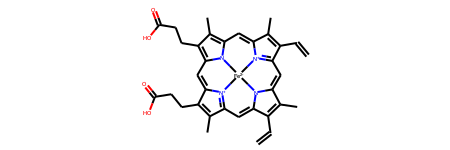

In [16]:
# and the depiction itself
result_2d.mol

Let's have a look at the example where molecular depiction cannot be drawn as collision free. We are going to use [Adamantone](https://www.ebi.ac.uk/pdbe-srv/pdbechem/chemicalCompound/show/ADO) as an example.

Depiction score is: 1.0


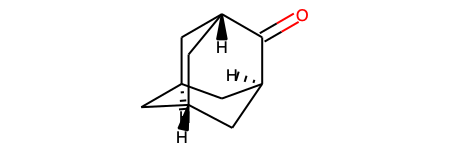

In [17]:
ado_path = download_component('ADO')
ado = ccd_reader.read_pdb_cif_file(ado_path).component
ado_depiction_result = ado.compute_2d(d)

print(f'Depiction score is: {ado_depiction_result.score}')
ado_depiction_result.mol


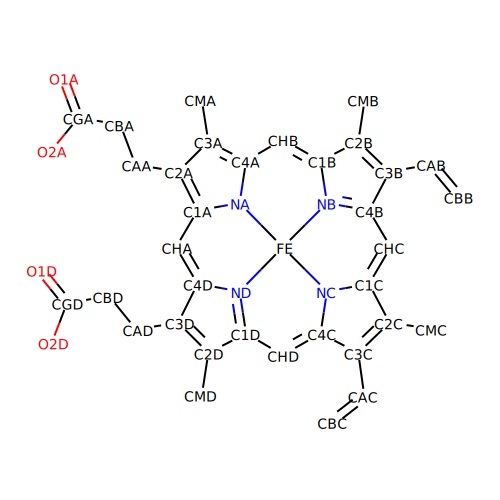

In [18]:
# we can also use convenient functions to store the depiction as an svg image:
component.export_2d_svg('HEM.svg')

# including atom names
component.export_2d_svg('HEM_with_names.svg', names=True)
SVG('HEM_with_names.svg')

We can also export the svg image and highlight atoms and bonds. Let's highlight the molecular scaffold we calculated earlier.

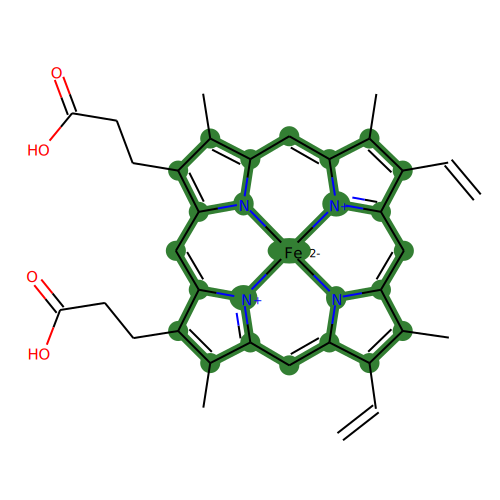

In [19]:
# retrieve list of atom names that are part of the scaffold 
# and color them in green. RGB: (0.2, 0.5, 0.2). 
# Scale 0-1 is used instead of the common 0-255
scaffold = component.scaffolds[0]
atom_names = scaffold.mappings[0]
atom_color_mapping = {x: (0.2, 0.5, 0.2) for x in atom_names}

# find out all the bonds that are formed among the scaffold atoms and color them in green as well.
bond_color_highlight = {}
bonds = component.mol_no_h.GetBonds()
for bond in bonds:
    begin = bond.GetBeginAtom().GetProp('name')
    end = bond.GetEndAtom().GetProp('name')

    if begin in atom_names and end in atom_names:
        bond_color_highlight[(begin, end)] = ((0.2, 0.5, 0.2))

# draw the final image
component.export_2d_svg('HEM_with_scaffold.svg', 
                        atom_highlight=atom_color_mapping,
                        bond_highlight=bond_color_highlight)
SVG('HEM_with_scaffold.svg')

The exactly same operations can be done by using input data from wwPDB BIRD dictionary. For the following example we are going to use [Vancomycin](https://en.wikipedia.org/wiki/Vancomycin), an antibiotic used for bacterial infection treatment. Just download `PRDCC_000204` wwPDB BIRD entry from the [FTP directory](ftp://ftp.wwpdb.org/pub/pdb/data/bird/prd/).

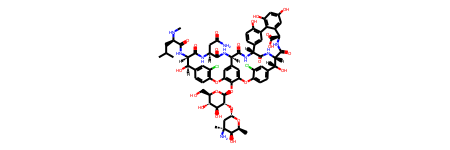

In [20]:
c = ccd_reader.read_pdb_cif_file('PRDCC_000204.cif').component
c.compute_2d(d).mol

## Structure writing

Structure writing can be done using `ccd_writer.py` module located in the `pdbeccdutils.core` module. This module exposes [write_molecule()](https://pdbeurope.github.io/ccdutils/pdbeccdutils.core.html#pdbeccdutils.core.ccd_writer.write_molecule) method that enables writing out conformers of chemical components in a number of different formats. See example below:

In [21]:
from pdbeccdutils.core import ccd_writer
from pdbeccdutils.core.models import ConformerType

# write out ideal conformer in the PDB format
ccd_writer.write_molecule('HEM_ideal.pdb', component, conf_type=ConformerType.Ideal)

# write out model conformer in the SDF format without hydrogens
ccd_writer.write_molecule('HEM_model_no_h.sdf',
                          component, remove_hs=True, conf_type=ConformerType.Model)

# write out metadata information in CML format
ccd_writer.write_molecule('HEM_in_cif.cml', component)

## Parity method

There is a number of chemical similarity methods that can estimate a degree of similarity between the two molecules. pdbeccdutils implements one of such methods that takes advantage of maximum common sub-structures. This method is called PARITY and was developed by Jon Tyzack while working at EBI. You can read the description of the method in the [published paper](https://doi.org/10.1016/j.str.2018.02.009).

In the following example we are going to examine molecular similarity of two heme variants [HEME A](http://pdbe.org/chem/HEA) and [HEME D](http://pdbe.org/chem/DHE)

In [22]:
# download the structures first
hem_a_path = download_component('HEA')
hem_d_path = download_component('DHE')

In [23]:
from pdbeccdutils.computations.parity_method import compare_molecules

hem_a = ccd_reader.read_pdb_cif_file(hem_a_path).component
hem_d = ccd_reader.read_pdb_cif_file(hem_d_path).component

result = compare_molecules(hem_a.mol_no_h, hem_d.mol_no_h)
result


ParityResult(mapping={0: 0, 5: 5, 6: 6, 1: 1, 35: 42, 31: 38, 32: 39, 4: 4, 27: 37, 23: 27, 24: 28, 3: 3, 21: 26, 17: 16, 18: 17, 2: 2, 9: 9, 8: 8, 7: 7, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 10: 10, 19: 18, 20: 20, 42: 22, 44: 23, 45: 25, 22: 19, 25: 29, 26: 31, 29: 33, 30: 34, 28: 30, 33: 40, 34: 41, 37: 44, 38: 45, 39: 46, 40: 47, 41: 48, 36: 43}, similarity_score=0.6029411764705882)

`ParityResult.mapping` contains left to right atom equivalency.

In [24]:
print(f'Similarity between heme A and heme D is: {result.similarity_score:.3f}.')

Similarity between heme A and heme D is: 0.603.


## Scripts

pdbeccdutils package implements also [scripts](https://pdbeurope.github.io/ccdutils/guide/pipelines.html) that we internally use for chemistry related processes in the PDBe. Directly from the package you can try out the PDBeChem that generates content of the [FTP area](http://ftp.ebi.ac.uk/pub/databases/msd/pdbechem_v2) and provides all the data that are consumed by the [service](http://pdbe.org/chem).